Epoch 1, Loss: 0.7712
Epoch 2, Loss: 0.3945
Epoch 3, Loss: 0.3482
Epoch 4, Loss: 0.3406
Epoch 5, Loss: 0.3276
Epoch 6, Loss: 0.3113
Epoch 7, Loss: 0.3108
Epoch 8, Loss: 0.2987
Epoch 9, Loss: 0.3038
Epoch 10, Loss: 0.2917
Epoch 11, Loss: 0.2851
Epoch 12, Loss: 0.2832
Epoch 13, Loss: 0.2853
Epoch 14, Loss: 0.2772
Epoch 15, Loss: 0.2865
Epoch 16, Loss: 0.2779
Epoch 17, Loss: 0.2670
Epoch 18, Loss: 0.2725
Epoch 19, Loss: 0.2714
Epoch 20, Loss: 0.2635
Epoch 21, Loss: 0.2704
Epoch 22, Loss: 0.2613
Epoch 23, Loss: 0.2678
Epoch 24, Loss: 0.2616
Epoch 25, Loss: 0.2676
Epoch 26, Loss: 0.2568
Epoch 27, Loss: 0.2619
Epoch 28, Loss: 0.2573
Epoch 29, Loss: 0.2558
Epoch 30, Loss: 0.2576
Epoch 31, Loss: 0.2540
Epoch 32, Loss: 0.2550
Epoch 33, Loss: 0.2531
Epoch 34, Loss: 0.2537
Epoch 35, Loss: 0.2576
Epoch 36, Loss: 0.2545
Epoch 37, Loss: 0.2498
Epoch 38, Loss: 0.2484
Epoch 39, Loss: 0.2445
Epoch 40, Loss: 0.2456
Epoch 41, Loss: 0.2460
Epoch 42, Loss: 0.2488
Epoch 43, Loss: 0.2473
Epoch 44, Loss: 0.24

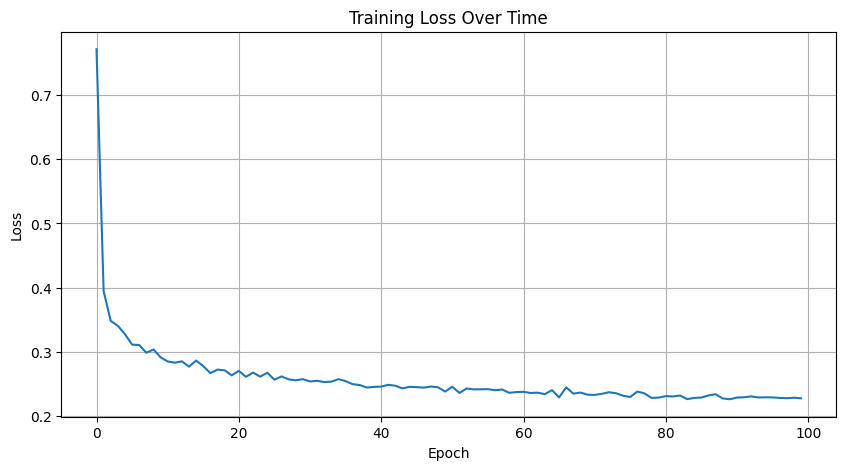

Prediction: trois quatre         Target: trois
Prediction: cinq zéro            Target: cinq zéro
Prediction: quatre quatre        Target: quatre
Prediction: trois trois          Target: trois
Prediction: cinq quatre          Target: cinq quatre

Accuracy on displayed samples: 40.00%


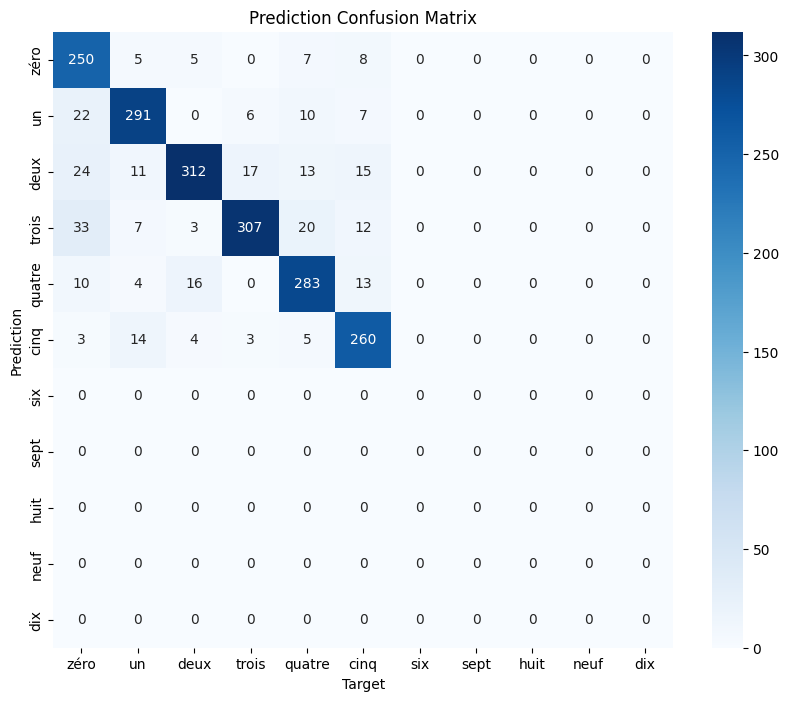

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

# Create a simple parallel dataset
class TranslationDataset:
    def __init__(self, num_samples=1000):
        # Create simple English-French number translations
        self.eng_numbers = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten']
        self.fr_numbers = ['zéro', 'un', 'deux', 'trois', 'quatre', 'cinq', 'six', 'sept', 'huit', 'neuf', 'dix']
        
        # Create vocabulary
        self.eng_vocab = {word: idx for idx, word in enumerate(self.eng_numbers)}
        self.fr_vocab = {word: idx for idx, word in enumerate(self.fr_numbers)}
        self.eng_vocab['<PAD>'] = len(self.eng_vocab)
        self.fr_vocab['<PAD>'] = len(self.fr_vocab)
        
        # Generate random sequences
        self.data = []
        for _ in range(num_samples):
            length = np.random.randint(1, 4)
            eng_seq = np.random.choice(self.eng_numbers[:6], size=length).tolist()
            fr_seq = [self.fr_numbers[self.eng_numbers.index(w)] for w in eng_seq]
            self.data.append((eng_seq, fr_seq))
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        eng_seq, fr_seq = self.data[idx]
        
        # Convert to indices and pad
        eng_indices = [self.eng_vocab[w] for w in eng_seq] + [self.eng_vocab['<PAD>']] * (3 - len(eng_seq))
        fr_indices = [self.fr_vocab[w] for w in fr_seq] + [self.fr_vocab['<PAD>']] * (3 - len(fr_seq))
        
        return (torch.tensor(eng_indices), torch.tensor(fr_indices))

# Transformer model
class SimpleTransformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=32, nhead=2, num_layers=2):
        super().__init__()
        self.embedding = nn.Embedding(src_vocab_size, d_model)
        self.pos_encoder = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU()
        )
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=64,
            batch_first=True
        )
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        
    def forward(self, src, tgt):
        src_embed = self.embedding(src)
        tgt_embed = self.embedding(tgt)
        
        # Add positional encoding
        src_pos = self.pos_encoder(src_embed)
        tgt_pos = self.pos_encoder(tgt_embed)
        
        # Create masks
        src_mask = None
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)
        
        output = self.transformer(src_pos, tgt_pos, src_mask, tgt_mask)
        return self.fc(output)

# Training and evaluation functions
def train_model(model, train_loader, criterion, optimizer, num_epochs=100):
    model.train()
    losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        for src, tgt in train_loader:
            optimizer.zero_grad()
            output = model(src, tgt[:, :-1])  # Shift target sequence
            loss = criterion(output.reshape(-1, output.size(-1)), tgt[:, 1:].reshape(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')
    
    return losses

def evaluate_model(model, test_loader, dataset):
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        for src, tgt in test_loader:
            output = model(src, tgt[:, :-1])
            pred = output.argmax(dim=-1)
            predictions.extend(pred.tolist())
            targets.extend(tgt[:, 1:].tolist())
    
    # Convert indices back to words
    rev_fr_vocab = {v: k for k, v in dataset.fr_vocab.items()}
    pred_words = [[rev_fr_vocab[idx] for idx in seq if idx != dataset.fr_vocab['<PAD>']] for seq in predictions]
    target_words = [[rev_fr_vocab[idx] for idx in seq if idx != dataset.fr_vocab['<PAD>']] for seq in targets]
    
    return pred_words, target_words

# Visualization functions
def plot_training_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

def plot_prediction_heatmap(predictions, targets, dataset, num_samples=5):
    correct = 0
    total = 0
    
    for pred, target in zip(predictions[:num_samples], targets[:num_samples]):
        pred_str = ' '.join(pred)
        target_str = ' '.join(target)
        print(f'Prediction: {pred_str:<20} Target: {target_str}')
        if pred_str == target_str:
            correct += 1
        total += 1
    
    accuracy = correct / total
    print(f'\nAccuracy on displayed samples: {accuracy:.2%}')
    
    # Create confusion matrix
    vocab_size = len(dataset.fr_vocab) - 1  # Exclude PAD token
    confusion = np.zeros((vocab_size, vocab_size))
    
    for pred_seq, target_seq in zip(predictions, targets):
        for p, t in zip(pred_seq, target_seq):
            if dataset.fr_vocab[p] < vocab_size and dataset.fr_vocab[t] < vocab_size:
                confusion[dataset.fr_vocab[p]][dataset.fr_vocab[t]] += 1
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion, 
                xticklabels=dataset.fr_numbers,
                yticklabels=dataset.fr_numbers,
                annot=True, 
                fmt='.0f',
                cmap='Blues')
    plt.title('Prediction Confusion Matrix')
    plt.xlabel('Target')
    plt.ylabel('Prediction')
    plt.show()

# Main execution
def main():
    # Create dataset and dataloaders
    dataset = TranslationDataset(num_samples=10000)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)
    
    # Initialize model and training components
    model = SimpleTransformer(
        src_vocab_size=len(dataset.eng_vocab),
        tgt_vocab_size=len(dataset.fr_vocab)
    )
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.fr_vocab['<PAD>'])
    optimizer = optim.Adam(model.parameters())
    
    # Train model
    losses = train_model(model, train_loader, criterion, optimizer)
    plot_training_loss(losses)
    
    # Evaluate and visualize results
    predictions, targets = evaluate_model(model, test_loader, dataset)
    plot_prediction_heatmap(predictions, targets, dataset)

if __name__ == "__main__":
    main()